# Visualization COVID spread

In the end of 2019 and so far in 2020 COVID19 (i.e. Corona Virus Infectious Disease), the disease generated by SARS-COV2, has spread from China to the World, is and will kill many people, specially old and already sick people.

To analyze how the virus spread into the world, I am creating a visualization that will be plotted using D3.js. But, before starting the visualization, we need to prepare the data that will be used as the framework input.

This notebook follows many points mapped in [this tutorial](https://github.com/nazareno/intro-d3-mapas/blob/master/1-cartografia-no-terminal.md), made by [Nazareno Andrade](https://github.com/nazareno), except the acquisition of the `.shp` and data files.

## 1. Obtaining the .SHP file with each country geometries

The .shp file was obtained in [this website](https://tapiquen-sig.jimdofree.com/english-version/free-downloads/world/), publicly provided by Carlos Efraín Porto Tapiquén.

After the download, I extracted the `.rar` file into the `data/` folder.

## 2. Transforming a .SHP file into a .geojson file

Following the instructions in the tutorial, we need to install a NodeJS module called `shapefile`. Differently from the tutorial I am not installing the modules globally, and I'll use another method to execute the modules. When a NodeJS module is installed, the executable files are placed inside the `node_modules/.bin/` folder. To run them, we can either use the path `../node_modules/.bin/<executable name>` or use npx: `npx <executable name>`.

**IMPORTANT**

In the execution of this notebook, I already executed `npm init` in the terminal. If you did not, please execute before continuing.

In [1]:
!npm install shapefile

npm WARN deprecated text-encoding@0.6.4: no longer maintainedKm
npm WARN covid@1.0.0 No descriptione shapefile@0.6.6~postinstall:K
npm WARN covid@1.0.0 No repository field.

+ shapefile@0.6.6m░░░░░░⸩ ⠇ postinstall: WARN covid@1.0.0 No repository field.
updated 1 package and audited 130 packages in 4.003s

1 package is looking for funding
  run `npm fund` for details

found 0 vulnerabilities

7m            ░░░░░░⸩ ⠙ postinstall: timing audit body Completed in 0ms

The `shapefile` module transforms a `.shp` file into a geojson file, which is easier to manipulate. I'll then use the shp2json command to apply this transformation:

In [46]:
!npx shp2json ../data/World_Countries.shp -o ../data/countries.json

## 3. The world as a plane

It is important to realize that the world is not flat, and that is why we all have seen globes in Geography classes and videos. If you haven't realized that, I recommend you to see [this video](https://www.vox.com/world/2016/12/2/13817712/map-projection-mercator-globe), that helped me have cleaner thoughs about this subject.

Our geojson also does not consider the world to be flat as well, and since we will be visualizing it in a plane (a screen), we have to fix the projection. The first step is to [choose the wanted projection](https://github.com/d3/d3-geo-projection) in this page, which is the list of projections that the projection library provide us.

Personally, I liked both `geoNaturalEarth1` and `Wagner6`. As said in the video, the cartographers like `Winkel3`, while Google maps is projected in `Mercator`. This really is your choice, and I'll follow with mine:

In [3]:
!npm install d3-geo-projection

npm WARN covid@1.0.0 No descriptione d3-geo-projection@2.8.1~post
npm WARN covid@1.0.0 No repository field.

+ d3-geo-projection@2.8.1⸩ ⠙ postinstall: WARN covid@1.0.0 No repository field.
updated 1 package and audited 130 packages in 3.509s

1 package is looking for funding
  run `npm fund` for details

found 0 vulnerabilities

7m            ░░░░░░⸩ ⠼ postinstall: timing audit body Completed in 0ms

In [4]:
!npx geoproject \
    'd3.geoNaturalEarth1().fitSize([1000, 600], d)' \
    < ../data/countries.json \
    > ../data/plane_countries.json

Its interesting to see how our projection is. Lets transform the json into a SVG and show it here in this notebook.

In [5]:
!npx geo2svg \
    -w 1000 -h 600 \
    < ../data/plane_countries.json \
    > ../images/natural.svg

In [6]:
from IPython.display import SVG, display
display(SVG(filename='../images/natural.svg'))

## 4. Using NDJson

To ease our data manipulation, it is interesting to transform the geojson generated into a ndjson (newline-delimited json). This process will be done using the `ndjson-cli` module.

In [7]:
!npm install ndjson-cli

npm WARN covid@1.0.0 No descriptione ndjson-cli@0.3.1~postinstall
npm WARN covid@1.0.0 No repository field.

+ ndjson-cli@0.3.1░░░░░░⸩ ⠏ postinstall: WARN covid@1.0.0 No repository field.
updated 1 package and audited 130 packages in 2.262s

1 package is looking for funding
  run `npm fund` for details

found 0 vulnerabilities

7m            ░░░░░░⸩ ⠹ postinstall: timing audit body Completed in 0ms

When looking inside the `plane_countries.json` file we just generated, we can see that it is an object that has an attribute called `features` that is an array and each object inside it is relative to a country. The next step is to map each object inside this array into a line, in order to create the `ndjson` file.

In [8]:
!npx ndjson-split 'd.features' \
    < ../data/plane_countries.json \
    > ../data/plane_countries.ndjson

## 5. Adding data to NDJson

Our data of interest is in the `data/covid_updated.json` file. The whole point here is to create a `ndjson` with that data, to later merge the ndjsons into a single file containing all the information. Differently from the last time we splitted, when looking inside the `covid_updated.json` file its possible to see the array itself, and not an object that contains the array of interest: this is why whe changed the string parameter from `d.features` to only `d`.

In [9]:
!npx ndjson-split 'd' \
    < ../data/covid_updated.json \
    > ../data/covid_data.ndjson

Now that the two ndjson files were generated, its possible to merge them into a single file. In order to do this, its necessary to have something to link an object in the first file to the object in the second file. In this example, its possible to identify each country by using the `COUNTRY` attribute in inside the attribute `properties` in the `planes_countries` file, and the `country` attribute in the `covid_data` file.

Since the attributes have different names and might be in inner objects, its interesting to place them with the same name in the same level. We will do this in the `plane_countries.ndjson`, mapping the `properties.COUNTRY` to a `country` attribute in the first level of the object:

In [10]:
!npx ndjson-map 'd.country = d.properties.COUNTRY, d' \
    < ../data/plane_countries.ndjson \
    > ../data/plane_countries_ortho.ndjson

Now that both `covid_data` and `plane_countries_ortho` have a linking attribute, we can merge them into a single file using `ndjson-join`. We are also using the `--left` parameter, that works similarly to a SQL Left Join, when merging the files.

In [41]:
!npx ndjson-join --left 'd.country' \
    ../data/plane_countries_ortho.ndjson \
    ../data/covid_data.ndjson \
    > ../data/covid_full.ndjson

When looking inside the resulting object, its possible to see that each line has become an array with 2 objects, the first is the object in `plane_countries_ortho` and the second is the object in `covid_data`. The next step is to make each line become a single object, as it was before the merge, and we will do this by mapping the attributes in the second object to the first.

If you are familiar with Object.assign, you can already skip and go continue to the next cell.

The JS line you can see below does the mapping using 3 parameters: an empty object, the first object in the array (d[0].properties), and the second object in the array (d[1]). But how do this work? Initially, all the `key:value` pairs in d[0].properties will be added in the empty object, then all the pairs in d[1] will be added in the object, replacing all d[0] pairs that had the same key. You might think "Why not to just write `Object.assign(d[0], d[1])`, since the point is to overwrite the values in the equal keys?". Well, the answer to that is that we do not want to use the memory allocated to d[0], and using an empty object prevents that, and we are avoiding to use the same memory because the result of the Object.assign operation will replace the current value of `d[0].properties`. This might be tricky to understand, but you shouldnt care too much about this if you understood what is the result.

In [31]:
!npx ndjson-map \
  'd[0].properties = Object.assign({}, d[0].properties, d[1]), d[0]' \
  < ../data/covid_full.ndjson \
  > ../data/covid_ortho_full.ndjson

## 6. Transforming data into TopoJson

Now a single file contains all the data that will be used. But the size of the file is around 16MB, a large file. The next step is to reduce the size of this file, keeping all most of the information, and this will be done using the `topojson` module

In [13]:
!npm install topojson

npm WARN deprecated topojson@3.0.2: Use topojson-client, topojson-server or topojson-simplify directly.
npm WARN covid@1.0.0 No descriptione topojson@3.0.2~postinstall:K
npm WARN covid@1.0.0 No repository field.

+ topojson@3.0.20m░░░░░░⸩ ⠦ postinstall: WARN covid@1.0.0 No repository field.
updated 1 package and audited 130 packages in 3.182s

1 package is looking for funding
  run `npm fund` for details

found 0 vulnerabilities

7m            ░░░░░░⸩ ⠏ postinstall: timing audit body Completed in 0ms

We will use the command `geo2topo`, that converts a `geojson` file into a `topojson` file.

In [32]:
!npx geo2topo -n \
    tracts=../data/covid_ortho_full.ndjson \
    > ../data/covid_topo.json

Now that the topojson was generated, we will use the `toposimplify` and the `topoquantize` commands to reduce the size of the file a little more.

In [33]:
!npx toposimplify -p 1 -f \
    < ../data/covid_topo.json \
    | ../node_modules/.bin/topoquantize 1e5 \
    > ../data/covid_quantized_topo.json

The map is now complete. It can be seen in the [mapshaper website](http://mapshaper.org/) by uploading the file we just generated, but you will not be able to see any data yet.

## 7. Back to GeoJson

Since the objective of this notebook is to generate a file that can be imported in JavaScript and used to create an interactive map in the browser, its interesting to go back from TopoJson to GeoJson, since it can be handled easier by d3.js.

After generating the file, its important to put the file in the `docs/data/` folder. The `docs/` folder is the folder that we are keeping our html project, and placing the data in a subfolder allows loading it without CORS problems (we do not want to get into that subject).

In [ ]:
!npx topo2geo tracts=- \
    < ../data/covid_quantized_topo.json \
    > ../data/covid_topo_features.json

!cp ../data/covid_topo_features.json ../docs/data/covid_topo_features.json

## 8. Generating map

Since we have not yet started to code in HTML+JS+CSS, its interesting to preview the resulting map that we will code later. For that, we will need to install `d3.js` and an auxiliar module that handles the scales of color, `d3-scale-chromatic`.

In [16]:
!npm install d3 d3-scale-chromatic

npm WARN covid@1.0.0 No descriptione d3@5.15.0~postinstall: d3@5.
npm WARN covid@1.0.0 No repository field.

+ d3@5.15.07m░░░░░░⸩ ⠏ postinstall: WARN covid@1.0.0 No repository field.
+ d3-scale-chromatic@1.5.0
added 4 packages from 1 contributor, updated 1 package and audited 226 packages in 3.394s

1 package is looking for funding
  run `npm fund` for details

found 0 vulnerabilities

7m            ░░░░░░⸩ ⠹ postinstall: timing audit body Completed in 0ms

The map and split commands from the `ndjson-cli` were previously used and here they are being used in the same way as before. The greater change was the use of pipes `|`. If you are not used to pipes, they work in a very simple way: lets say you execute the program A.py using `python A.py` and it prints "Hello World". If you have a program B.py that prints whatever is inputted from the start to the beginning, using `python A.py | python B.py` would result in printing "dlroW olleH". Its easy now to resume what it does by saying that "the Pipe operator passes the return of the first command as input to the second command".

In [44]:
!npx ndjson-map -r d3 \
    'z = d3.scaleSequential(d3.interpolateBlues).domain([0, 1e4]), d.features.forEach(f => f.properties.fill = z(f.properties.confirmed ? f.properties.confirmed[f.properties.confirmed.length - 1] : 0)), d' \
    < ../data/covid_topo_features.json \
    | npx ndjson-split 'd.features' \
    | npx geo2svg -n --stroke none -w 1000 -h 600 \
    > ../images/covid.svg

Visualizing the SVG we generated, we have this:

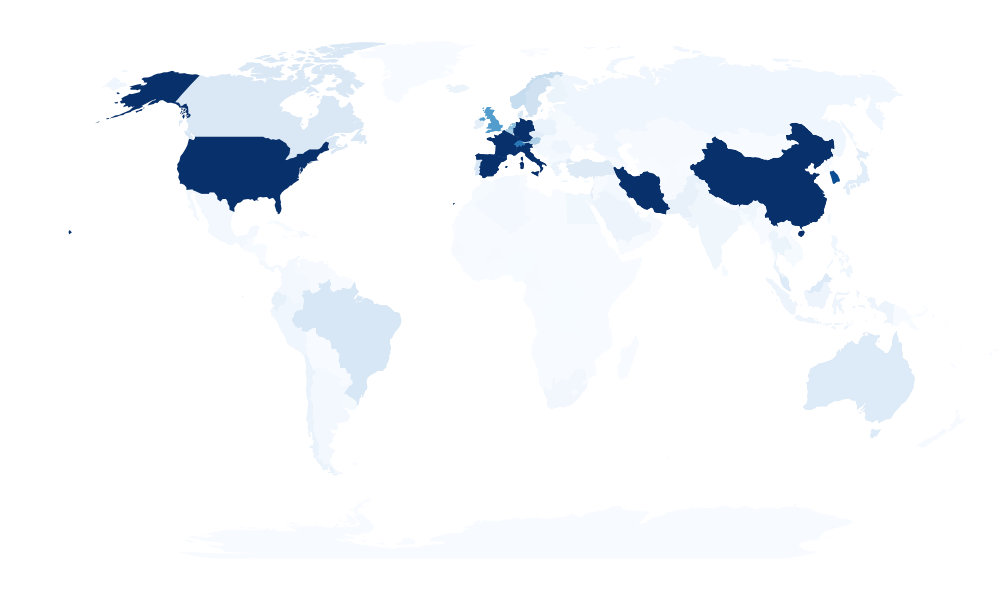

In [45]:
from IPython.display import SVG, display
display(SVG(filename='../images/covid.svg'))